# **This model generates a story on the by extracting the features of an input Image**

# So basically, it consists of 3 submodels in it:
#    1. Feature extraction model by extracting a layer from a image classification model (Computer Vision)
#    2. LSTM model, trained on a dataset with predefined captions (Natural Language Processing)
#    3. A Top-p (nucleus) sampling model using transformers, which generate a story from the captions generated (Natural Language Processing)

# **PLEASE NOTE: I have trained this model before, and downloaded the extracted feature file. But after that the outputs got resetted and I cant train this model again because my kaggle weekly GPU limit is reached. However, this model is a working one**

# In this model, I have trained an Image classifier from scratch using RESNET architecture, and then downloaded the extracted features for all images in the dataset in "custom_resnet_features.pkl", which is then passed into the next model, in the next jupyter notebook

# IMPORT

In [2]:
from os import listdir
from pickle import dump
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import concatenate, BatchNormalization, Input
from keras.callbacks import ModelCheckpoint

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torchvision
import torch.nn as nn




import torch.nn.functional as F
from torchvision.datasets import CIFAR100
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, ConcatDataset
import torchvision.transforms as tt


# preprocess

In [4]:
stats = ((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025))
train_transform = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.RandomCrop(32, padding=4, padding_mode="reflect"),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

test_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])

In [5]:
train_data = CIFAR100(download=True, root="./data", transform=train_transform)
test_data = CIFAR100(root="./data", train=False, transform=test_transform)

100%|██████████| 169001437/169001437 [00:03<00:00, 48881662.74it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


In [6]:
for image, label in train_data:
    print("Image shape: ",image.shape)
    print("Image tensor: ", image)
    print("Label: ", label)
    break

Image shape:  torch.Size([3, 32, 32])
Image tensor:  tensor([[[ 2.4495,  2.4300,  2.4495,  ...,  0.5385,  0.2850, -0.0660],
         [ 2.4495,  2.4300,  2.4495,  ...,  0.7335,  0.3825, -0.1831],
         [ 2.4495,  2.4300,  2.4495,  ...,  1.1625,  0.7140, -0.1636],
         ...,
         [ 0.2460,  0.4020,  0.5385,  ..., -1.2361, -0.9826, -0.5341],
         [ 0.7920,  0.7140,  0.7530,  ..., -1.0411, -0.9046, -0.4951],
         [ 0.6750,  0.8115,  1.0260,  ..., -1.0996, -0.9436, -0.6706]],

        [[ 2.5833,  2.5636,  2.5833,  ...,  0.7873,  0.5505,  0.1755],
         [ 2.5833,  2.5636,  2.5833,  ...,  1.1228,  0.7478,  0.1360],
         [ 2.5833,  2.5636,  2.5833,  ...,  1.4781,  1.0636,  0.1755],
         ...,
         [ 1.2018,  1.3597,  1.4978,  ..., -1.5613, -1.2850, -0.7521],
         [ 1.6557,  1.5767,  1.6360,  ..., -1.3245, -1.1468, -0.6929],
         [ 1.5767,  1.7149,  1.8925,  ..., -1.3442, -1.1271, -0.7719]],

        [[ 2.7600,  2.7406,  2.7600,  ...,  0.1069,  0.0294, -0

In [7]:
train_classes_items = dict()

for train_item in train_data:
    label = train_data.classes[train_item[1]]
    if label not in train_classes_items:
        train_classes_items[label] = 1
    else:
        train_classes_items[label] += 1

train_classes_items

{'cattle': 500,
 'dinosaur': 500,
 'apple': 500,
 'boy': 500,
 'aquarium_fish': 500,
 'telephone': 500,
 'train': 500,
 'cup': 500,
 'cloud': 500,
 'elephant': 500,
 'keyboard': 500,
 'willow_tree': 500,
 'sunflower': 500,
 'castle': 500,
 'sea': 500,
 'bicycle': 500,
 'wolf': 500,
 'squirrel': 500,
 'shrew': 500,
 'pine_tree': 500,
 'rose': 500,
 'television': 500,
 'table': 500,
 'possum': 500,
 'oak_tree': 500,
 'leopard': 500,
 'maple_tree': 500,
 'rabbit': 500,
 'chimpanzee': 500,
 'clock': 500,
 'streetcar': 500,
 'cockroach': 500,
 'snake': 500,
 'lobster': 500,
 'mountain': 500,
 'palm_tree': 500,
 'skyscraper': 500,
 'tractor': 500,
 'shark': 500,
 'butterfly': 500,
 'bottle': 500,
 'bee': 500,
 'chair': 500,
 'woman': 500,
 'hamster': 500,
 'otter': 500,
 'seal': 500,
 'lion': 500,
 'mushroom': 500,
 'girl': 500,
 'sweet_pepper': 500,
 'forest': 500,
 'crocodile': 500,
 'orange': 500,
 'tulip': 500,
 'mouse': 500,
 'camel': 500,
 'caterpillar': 500,
 'man': 500,
 'skunk': 500

In [8]:
test_classes_items = dict()
for test_item in test_data:
    label = test_data.classes[test_item[1]]
    if label not in test_classes_items:
        test_classes_items[label] = 1
    else:
        test_classes_items[label] += 1

test_classes_items

{'mountain': 100,
 'forest': 100,
 'seal': 100,
 'mushroom': 100,
 'sea': 100,
 'tulip': 100,
 'camel': 100,
 'butterfly': 100,
 'cloud': 100,
 'apple': 100,
 'skunk': 100,
 'streetcar': 100,
 'rocket': 100,
 'lamp': 100,
 'lion': 100,
 'wolf': 100,
 'rose': 100,
 'orange': 100,
 'dinosaur': 100,
 'chimpanzee': 100,
 'can': 100,
 'keyboard': 100,
 'bicycle': 100,
 'chair': 100,
 'plate': 100,
 'lawn_mower': 100,
 'turtle': 100,
 'palm_tree': 100,
 'shark': 100,
 'pickup_truck': 100,
 'boy': 100,
 'couch': 100,
 'house': 100,
 'porcupine': 100,
 'cockroach': 100,
 'clock': 100,
 'castle': 100,
 'beaver': 100,
 'bee': 100,
 'bottle': 100,
 'pear': 100,
 'baby': 100,
 'flatfish': 100,
 'oak_tree': 100,
 'leopard': 100,
 'snail': 100,
 'crocodile': 100,
 'rabbit': 100,
 'beetle': 100,
 'girl': 100,
 'sunflower': 100,
 'raccoon': 100,
 'train': 100,
 'ray': 100,
 'trout': 100,
 'bowl': 100,
 'snake': 100,
 'orchid': 100,
 'tractor': 100,
 'caterpillar': 100,
 'bus': 100,
 'mouse': 100,
 'cr

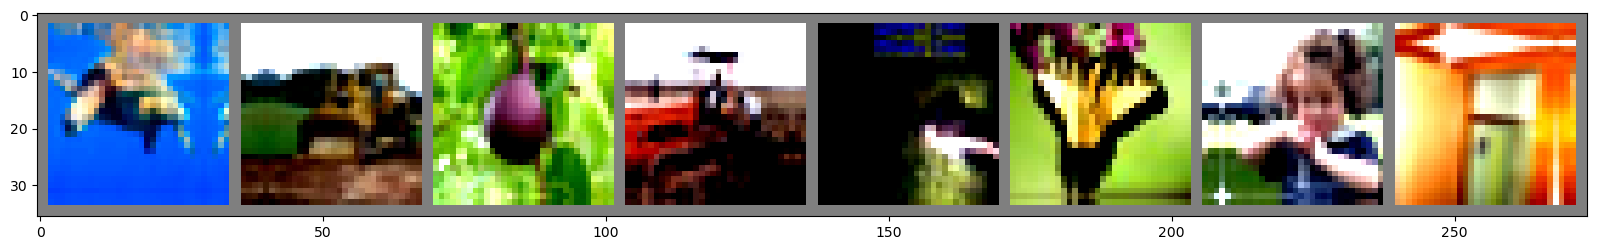

turtle              tractor             pear                tractor             skunk               butterfly           girl                wardrobe            


In [9]:
# for 8 images
train_8_samples = DataLoader(train_data, 8, num_workers=2, pin_memory=True, shuffle=True)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_8_samples)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print(''.join(f'{train_data.classes[labels[j]]:20s}' for j in range(8)))

In [10]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)


class ToDeviceLoader:
    def __init__(self,data,device):
        self.data = data
        self.device = device
        
    def __iter__(self):
        for batch in self.data:
            yield to_device(batch,self.device)
            
    def __len__(self):
        return len(self.data)


In [11]:
device = get_device()
print(device)
train_dl = DataLoader(train_data, batch_size=8, num_workers=2, pin_memory=True, shuffle=True)
test_dl = DataLoader(test_data, batch_size=8, num_workers=2, pin_memory=True)

train_dl = ToDeviceLoader(train_dl, device)
test_dl = ToDeviceLoader(test_dl, device)

cpu


In [12]:
device = get_device()
print(device)
train_dl = DataLoader(train_data, batch_size=8, num_workers=2, pin_memory=True, shuffle=True)
test_dl = DataLoader(test_data, batch_size=8, num_workers=2, pin_memory=True)

train_dl = ToDeviceLoader(train_dl, device)
test_dl = ToDeviceLoader(test_dl, device)

cpu


In [13]:
def accuracy(predicted, actual):
    _, predictions = torch.max(predicted, dim=1)
    return torch.tensor(torch.sum(predictions==actual).item()/len(predictions))

In [14]:
class BaseModel(nn.Module):
    def training_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {"val_loss":loss.detach(),"val_acc":acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses = [loss["val_loss"] for loss in outputs]
        loss = torch.stack(batch_losses).mean()
        batch_accuracy = [accuracy["val_acc"] for accuracy in outputs]
        acc = torch.stack(batch_accuracy).mean()
        return {"val_loss":loss.item(),"val_acc":acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

# MODEL

In [15]:
def conv_shortcut(in_channel, out_channel, stride):
    layers = [nn.Conv2d(in_channel, out_channel, kernel_size=(1,1), stride=(stride, stride)),
             nn.BatchNorm2d(out_channel)]
    return nn.Sequential(*layers)

def block(in_channel, out_channel, k_size,stride, conv=False):
    layers = None
    
    first_layers = [nn.Conv2d(in_channel,out_channel[0], kernel_size=(1,1),stride=(1,1)),
                    nn.BatchNorm2d(out_channel[0]),
                    nn.ReLU(inplace=True)]
    if conv:
        first_layers[0].stride=(stride,stride)
    
    second_layers = [nn.Conv2d(out_channel[0], out_channel[1], kernel_size=(k_size, k_size), stride=(1,1), padding=1),
                    nn.BatchNorm2d(out_channel[1])]

    layers = first_layers + second_layers
    
    return nn.Sequential(*layers)
    

class ResNet(BaseModel):
    
    def __init__(self, in_channels, num_classes):
        super().__init__()
         
        self.stg1 = nn.Sequential(
                                   nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=(3),
                                             stride=(1), padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(inplace=True),
                                   nn.MaxPool2d(kernel_size=3, stride=2))
        
        ##stage 2
        self.convShortcut2 = conv_shortcut(64,256,1)
        
        self.conv2 = block(64,[64,256],3,1,conv=True)
        self.ident2 = block(256,[64,256],3,1)

        
        ##stage 3
        self.convShortcut3 = conv_shortcut(256,512,2)
        
        self.conv3 = block(256,[128,512],3,2,conv=True)
        self.ident3 = block(512,[128,512],3,2)

        
        ##stage 4
        self.convShortcut4 = conv_shortcut(512,1024,2)
        
        self.conv4 = block(512,[256,1024],3,2,conv=True)
        self.ident4 = block(1024,[256,1024],3,2)
        self.fc1=nn.Linear(1024,4096)
        
        ##Classify
        self.classifier = nn.Sequential(
                                       nn.AvgPool2d(kernel_size=(4)),
                                       nn.Flatten(),
                                       nn.Linear(1024, 4096))
        

    def forward(self, inputs):
        out = self.stg1(inputs)
        
        #stage 2
        out = F.relu(self.conv2(out) + self.convShortcut2(out))
        out = F.relu(self.ident2(out) + out)
        out = F.relu(self.ident2(out) + out)
        out = F.relu(self.ident2(out) + out)
        
        #stage3
        out = F.relu(self.conv3(out) + (self.convShortcut3(out)))
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        
        #stage4             
        out = F.relu(self.conv4(out) + (self.convShortcut4(out)))
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        
        # Output layer (your original classifier layer)
        out = self.classifier(out) # 100x1024
        
        return out

    # Add a new method to return the intermediate features
    def extract_features(self, inputs):
        out = self.stg1(inputs)
        out = F.relu(self.conv2(out) + self.convShortcut2(out))
        out = F.relu(self.ident2(out) + out)
        out = F.relu(self.ident2(out) + out)
        out = F.relu(self.ident2(out) + out)
        
        out = F.relu(self.conv3(out) + (self.convShortcut3(out)))
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        
        out = F.relu(self.conv4(out) + (self.convShortcut4(out)))
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        
        # Global average pooling
        out = F.adaptive_avg_pool2d(out, (1, 1))
        
        # Flatten the features
        out = out.view(out.size(0), -1)
#         out = F.linear(self.ident4(out) + out)
#         out= nn.Linear(1024, 4096)
        out=self.fc1(out)
        return out

        

In [16]:
@torch.no_grad()
def evaluate(model,test_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_dl]
    return model.validation_epoch_end(outputs)

In [17]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit (epochs, train_dl, test_dl, model, optimizer, max_lr, weight_decay, scheduler, grad_clip=None):
    torch.cuda.empty_cache()
    
    history = []
    
    optimizer = optimizer(model.parameters(), max_lr, weight_decay = weight_decay)
    
    scheduler = scheduler(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train()
        
        train_loss = []
        
        lrs = []
        
        for batch in train_dl:
            loss = model.training_step(batch)
            
            train_loss.append(loss)
            
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            scheduler.step()
            lrs.append(get_lr(optimizer))
        result = evaluate(model, test_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        
        model.epoch_end(epoch,result)
        history.append(result)
        
    return history
            
    

In [18]:
epochs = 20
optimizer = torch.optim.Adam
max_lr = 1e-3
grad_clip = 0.1
weight_decay = 1e-5
scheduler = torch.optim.lr_scheduler.OneCycleLR

In [19]:
model = ResNet(in_channels=3, num_classes=100)  # Create an instance of the ResNet class
model = model.to(device)  # Move the model to the appropriate device (CPU or GPU)

# MODEL TRAINING

In [ ]:
%%time
history = fit(epochs=epochs, train_dl=train_dl, test_dl=test_dl, model=model, 
              optimizer=optimizer, max_lr=max_lr, grad_clip=grad_clip,
              weight_decay=weight_decay, scheduler=torch.optim.lr_scheduler.OneCycleLR)

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return test_data.classes[preds[0].item()]
img, label = test_data[3]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_data.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
torch.save(model.state_dict(), 'path_to_your_trained_model.pth')

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
model = ResNet(in_channels=3, num_classes=100)  # Replace 'in_channels' and 'num_classes' with appropriate values
model.load_state_dict(torch.load('path_to_your_trained_model.pth'))
model.eval()

In [ ]:
from torchvision import transforms
# Modify the extract_custom_resnet_features function to use the extract_features method
def extract_custom_resnet_features(directory, model):
    features = dict()
    for name in listdir(directory):
        filename = directory + '/' + name
        # Load and preprocess the image
        
        image = load_img(filename, target_size=(224, 224))
#         image = Image.open(filename).convert('RGB')
        preprocess = transforms.Compose([
            transforms.Resize(32),
            transforms.CenterCrop(32),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5074, 0.4867, 0.4411], std=[0.2011, 0.1987, 0.2025]),
        ])
        image_tensor = preprocess(image)
        image_tensor = image_tensor.unsqueeze(0)

        # Extract features from the image using your trained ResNet model
        with torch.no_grad():
            feature = model.extract_features(image_tensor)

#         Flatten the features and convert to a numpy array
#         feature = feature.squeeze().numpy()
        # Get the image id (without file extension)
        image_id = name.split('.')[0]
        features[image_id] = feature
        print('>%s' % name)

    return features

# Replace the VGG16 feature extraction with your trained ResNet feature extraction
# directory = 'D:\\Data_Science\\csoc\\week4\\Flickr8k_Dataset\\Flicker8k_Dataset\\'
directory = '/kaggle/input/flickr8k/Images/'
features = extract_custom_resnet_features(directory, model)
print('Extracted Features: %d' % len(features))
# Save to file
dump(features, open('custom_resnet_features.pkl', 'wb'))

# model = create_cnn_model(input_shape=(224, 224, 3))
    # Load the weights of the pre-trained model (optional)
    # model.load_weights('pretrained_weights.h5')
# features = dict()

# for name in listdir(directory):
#     filename = directory + '/' + name
#     image = load_img(filename, target_size=(224, 224))
#     feature = predict_image(image, model)

#     image = img_to_array(image)
#     image = np.expand_dims(image, axis=0)
#     image = preprocess_input(image)

#     image_id = name.split('.')[0]
#     features[image_id] = feature
#     print('>%s' % name)
# print('Extracted Features: %d' % len(features))
# # save to file
# dump(features, open('features.pkl', 'wb'))


# MODEL PLOTTING

In [ ]:
def plot_acc(history):
    plt.plot([x["val_acc"] for x in history],"-x")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

def plot_loss(history):
    plt.plot([x.get("train_loss") for x in history], "-bx")
    plt.plot([x["val_loss"] for x in history],"-rx")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train loss","val loss"])
    
def plot_lrs(history):
    plt.plot(np.concatenate([x.get("lrs",[]) for x in history]))
    plt.xlabel("Batch number")
    plt.ylabel("Learning rate")

In [ ]:
plot_loss(history)

In [ ]:
plot_acc(history)

In [ ]:
plot_lrs(history)

# Testing image

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return test_data.classes[preds[0].item()]

In [ ]:
img, label = test_data[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_data.classes[label], ', Predicted:', predict_image(img, model))